In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow as tf
import os, time, copy
from bridgedeterioration import BridgeEnv
from policynet import CNNPolicy
from utils import getreturn, experience_buffer, processsa
# from pretrain import  pretrain
os.environ["CUDA_VISIBLE_DEVICES"]="-1"
env = BridgeEnv()
start = time.time()

batch_size = 1000; update_freq = 1
startE = 1; endE = 0.01; anneling_steps = int(1e3); e_step = (startE-endE)/anneling_steps; e = startE
num_episodes = int(5e4); pre_train_steps = int(1e4)
# startAlpha = 1; endAlpha = 0.1; Alpha_step = (startAlpha-endAlpha)/1e4

loadmodel = False

tf.reset_default_graph()
mH = 128; gamma = 0.95; alpha = 1
mainQN = CNNPolicy(); mainQN.create_network(mH)
init = tf.global_variables_initializer()
saver = tf.train.Saver(max_to_keep=1000)
myBuffer = experience_buffer(pre_train_steps)

costs = [0]; DQNloss = [0]; Q_dict = {}
if not os.path.exists('./result'):
    os.makedirs('./result')
networkmodel = './result/training result/'

# guidebuffer = pretrain(gamma)
sess = tf.Session()
sess.run(init)

if loadmodel:
    ckpt = tf.train.get_checkpoint_state(networkmodel)
    saver.restore(sess, ckpt.model_checkpoint_path)

for i_episode in range(num_episodes+1):
    episodeBuffer = experience_buffer(pre_train_steps)

    state = env.reset()
    s = np.reshape(state,[49])
    done = False
    rAll = 0; t = 0
    states = np.zeros([100,49])
    actions = np.zeros([100,7])
    codeactions = np.zeros([100,28])
    states1 = np.zeros([100,49])
    rewards = np.zeros([100,7])
    dones = np.zeros([100,1])
    rnd = np.random.rand()

    while not done:
        states[t] = copy.deepcopy(s)

        a = np.zeros(7,dtype=np.int32)
        if rnd < e:
            a = np.random.randint(0,4,7)
        else:
            a = sess.run(mainQN.predict, feed_dict={mainQN.scalarInput:[s]})[0]

        state1, reward, done = env.step(a)
        r = reward/600
        s1 = np.reshape(state1,[49])
        code_a = np.reshape(processsa(a,4),[28])

        states1[t] = copy.deepcopy(s1); rewards[t] = copy.deepcopy(r); actions[t] = copy.deepcopy(a)
        codeactions[t] = copy.deepcopy(code_a); dones[t] = copy.deepcopy(done)
        s = s1; t+=1
    G = getreturn(rewards,gamma=gamma)
    costs.append(np.sum(rewards))
    if i_episode%100==0:
        print(str(i_episode),'*******', round(e,4), '*******', round(alpha,4),'*******', round(costs[-1],4), '*******',  round(DQNloss[-1],5), '*******', round(time.time() - start,1))
    
    
    
    i=99
    s = states[i]; a = actions[i]; Q = G[i]; s1 = states1[i]; d = dones[i]; code_a = codeactions[i]; r = rewards[i]
    state = np.int32(np.reshape(s,[7,7]))
    _, state_num = np.where(state[:,0:6]==1)
    for component in range(7):
        tuple_idx = (component, state_num[component], a[component], i)
        if Q_dict.get(tuple_idx):
            n_times,Q_value = Q_dict[tuple_idx]
            n_times += 1
            Q_value += (Q[component]-Q_value)
            Q_dict[tuple_idx] = (n_times, Q_value)
        else:
            n_times = 0
            Q_value = Q[component]
            Q_dict[tuple_idx] = (n_times, Q_value)
        Q[component] = Q_value
    episodeBuffer.add(np.reshape(np.array([s,a,Q,r,s1,d,code_a]),[1,7]))
    
    for i in range(98, -1,-1):
        s = states[i]; a = actions[i]; Q = G[i]; s1 = states1[i]; d = dones[i]; code_a = codeactions[i]; r = rewards[i]
        state = np.int32(np.reshape(s,[7,7]))
        _, state_num = np.where(state[:,0:6]==1)
        state1 = np.int32(np.reshape(s1,[7,7]))
        _, state_num1 = np.where(state1[:,0:6]==1)
        a = np.int32(a)
        for component in range(7):
            tuple_idx = (component, state_num[component], a[component], i)
            
            Q1 = []
            for i_a in range(4):
                tuple_idx1 = (component, state_num1[component], i_a, i+1)
                if Q_dict.get(tuple_idx1):
                    Q1.append(Q_dict[tuple_idx1][1])
           
            if Q_dict.get(tuple_idx):
                n_times,Q_value = Q_dict[tuple_idx]
                n_times += 1
#                 alpha = e*10
#                 alpha = 1/n_times
                Q_value += (r[component]+gamma*max(Q1)-Q_value)*alpha
                Q_dict[tuple_idx] = (n_times, Q_value)
            else:
                n_times = 0
                Q_value = r[component]+gamma*max(Q1)
                Q_dict[tuple_idx] = (n_times, Q_value)
            Q[component] = Q_value
        episodeBuffer.add(np.reshape(np.array([s,a,Q,r,s1,d,code_a]),[1,7]))
    myBuffer.add(episodeBuffer.buffer)

#     if e>endE:
#         e -= e_step
    
    e = 1000/(1000+i_episode)
    
#     if alpha>endAlpha:
# #         e = 10/(i_episode+1)
#         alpha -= Alpha_step
    
    alpha = 300/(300+i_episode)
    
    
    if i_episode >100 and (i_episode%update_freq == 0):
#         if e>endE:
#             e -= e_step
        trainBatch = myBuffer.sample(batch_size)
        input_s = np.vstack(trainBatch[:,0])
        input_a = np.vstack(trainBatch[:,1])
        target_Q = np.vstack(trainBatch[:,2])

        _, qloss = sess.run([mainQN.updateModel,mainQN.loss],
                 feed_dict={mainQN.scalarInput:input_s, mainQN.actions:input_a, mainQN.targetQ:target_Q})
        DQNloss.append(qloss)

    if i_episode%5000 == 0:
        print(rnd>e)
        filepath = './result/training results/step' + str(i_episode)
        if not os.path.exists(filepath):
            os.makedirs(filepath)
        saver.save(sess, filepath+'/training-'+str(i_episode)+'.cpkt')
        np.save(filepath+'/costs.npy', costs)
        np.save(filepath+'/DQNloss.npy', DQNloss)
        np.save(filepath+'/Q_dict.npt',Q_dict)
        print("Save Model")
        elapsed = time.time()-start
        print(i_episode,e,elapsed,costs[-1])
        state,_ = env.randomint()
        print(state)
        s = np.reshape(state,[49])
        print(sess.run(mainQN.predict,feed_dict={mainQN.scalarInput:[s]})[0])
        start = time.time()

##################################### Test Greedy Policy ##################################
    if i_episode%20 == 0:    
        horizon = 100
        state = env.reset()
        s = np.reshape(state,[49])
        num_component = 7
        #print(state)
        done = False
        t, rAll = 0, 0
        while not done:
            a = sess.run(mainQN.predict, feed_dict={mainQN.scalarInput: [s]})[0]    
            state1, reward, done = env.step(a)
            r = reward / 600
            state1 = env.state
            s1 = np.reshape(state1,[49])
            s = s1
            t += 1
            # year = time_encoder(t, 7)[np.newaxis, np.newaxis, :]
            rAll += np.sum(r)
        print(rAll)
##################################### Test Greedy Policy ##################################
        
sess.close()


In [4]:
from tqdm.notebook import trange, tqdm
num_component = 7
episodes = 10000

horizon = 100

costs = []
actions = np.zeros([episodes, horizon, num_component], dtype=np.int32)
states = np.zeros([episodes, horizon, num_component], dtype=np.int32)
for i in trange(episodes):
    _ = env.reset()
    state = env.reset()
    s = np.reshape(state,[49])
    #print(state)
    done = False
    t, rAll = 0, 0
    while not done:
        a = sess.run(mainQN.predict, feed_dict={mainQN.scalarInput: [s]})[0]
#         a = np.random.randint(0,4,num_component)
#         a = np.random.randint(0,1,num_component)

#         a = np.zeros(num_component, dtype=np.int32)
#         a[np.where(state1[:,0] == 0)] = 1  # condition-1
        
#         print(a)
#         print(state)
        states[i, t, :] = copy.deepcopy(env.state_num[:num_component])
        actions[i, t, :] = copy.deepcopy(a)
        state1, reward, done = env.step(a)
        r = reward / 600
        state1 = env.state
        s1 = np.reshape(state1,[49])
        s = s1
        t += 1
        # year = time_encoder(t, 7)[np.newaxis, np.newaxis, :]
        rAll += np.sum(r)
#     print(i)
#     print(rAll)
    costs.append(rAll)
#     print(np.mean(costs))
np.mean(costs)

-1.3879180166666674

In [5]:
np.std(costs)

0.06789925231432355

(array([   4.,    7.,   24.,   48.,  110.,  220.,  363.,  575.,  868.,
        1128., 1372., 1448., 1319.,  996.,  754.,  432.,  219.,   75.,
          32.,    6.]),
 array([-1.65733333, -1.63305   , -1.60876667, -1.58448333, -1.5602    ,
        -1.53591667, -1.51163333, -1.48735   , -1.46306667, -1.43878333,
        -1.4145    , -1.39021667, -1.36593333, -1.34165   , -1.31736667,
        -1.29308333, -1.2688    , -1.24451667, -1.22023333, -1.19595   ,
        -1.17166667]),
 <a list of 20 Patch objects>)

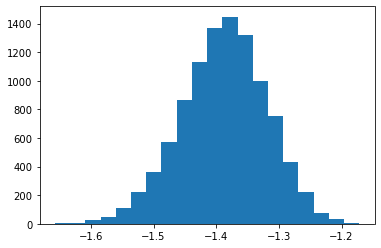

In [6]:
import matplotlib.pyplot as plt
plt.hist(costs,20)

In [ ]:
# state,_ = env.randomint()
state = env.reset()
print(state)
s = np.reshape(state,[49])
print(sess.run(mainQN.predict,feed_dict={mainQN.scalarInput:[s]})[0])

In [ ]:
e_step

In [8]:
ind = [(i+1)*10 for i in range(4990)]

In [9]:
COST = np.load('./result/training results/step50000/costs.npy')

Text(0, 0.5, 'Total Cost')

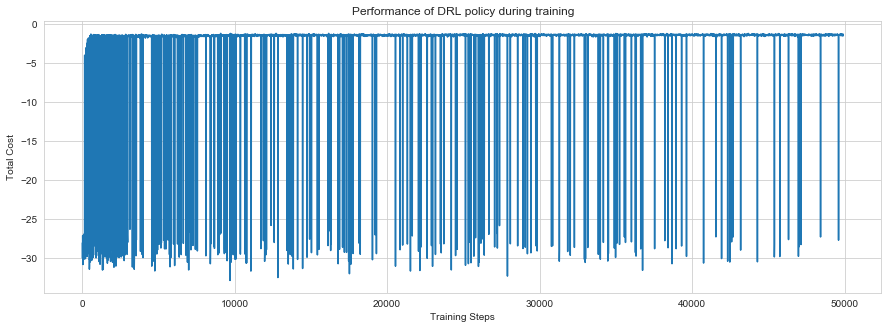

In [10]:
import seaborn as sns
plt.figure(figsize=(15, 5))
sns.set_style("whitegrid")
plt.plot(ind, [COST[i] for i in ind])
plt.title("Performance of DRL policy during training")
plt.xlabel("Training Steps")
plt.ylabel("Total Cost")

In [11]:
DQNloss = np.load('./result/training results/step50000/DQNloss.npy')

Text(0, 0.5, 'Loss')

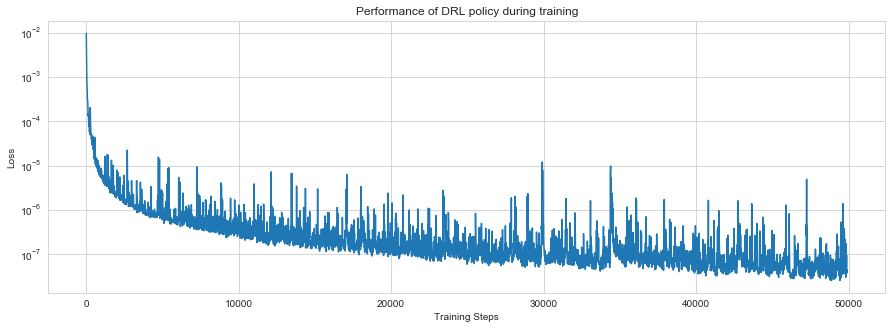

In [12]:
plt.figure(figsize=(15, 5))
sns.set_style("whitegrid")
plt.plot(ind, [DQNloss[i] for i in ind])
plt.yscale('log')
plt.title("Performance of DRL policy during training")
plt.xlabel("Training Steps")
plt.ylabel("Loss")